In [1]:
import sys
sys.path.append('..')

import dotenv
from huggingface_hub import login
import os
from transformers import AutoTokenizer, AutoModelForCausalLM
from src.utils import read_config, plot_gender_distribution, BiasEvaluator, LocalLLMGenerator, concurrent_bias_evaluation
from openai import OpenAI
from src.prompts import prompt_story_generation, prompt_gender_detection
from peft import PeftModel


dotenv.load_dotenv()
login(token=os.getenv('huggingface_token'))


%load_ext autoreload
%autoreload 2

/home/kaysinbd/Programs/my_projects/kaysinb/GenderBias-LLM/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
openai_client = OpenAI(
    api_key=os.getenv('openai_api_key'),
)

llm_configs = read_config('../configs/llm_config.yaml')
generation_config = read_config('../configs/generation_config.yaml')
print(generation_config)
print(llm_configs)

{'n_samples': 10}
{'local_generative_model_name': 'Qwen/Qwen2.5-0.5B-Instruct', 'chatgpt_generative_model_name': 'gpt-4o-2024-11-20', 'gpt_model_to_check_gender': 'gpt-4o-2024-11-20'}


In [3]:
bias_evaluator = BiasEvaluator(openai_client, llm_configs['gpt_model_to_check_gender'], prompt_gender_detection)


# Local LLM evaluation

In [4]:
local_model_name = llm_configs['local_generative_model_name']
tokenizer = AutoTokenizer.from_pretrained(local_model_name)
model = AutoModelForCausalLM.from_pretrained(local_model_name)



In [7]:
checkpoint_dir = "../test/gender_only_ckpt/checkpoint-500"
lora_model = PeftModel.from_pretrained(model, checkpoint_dir)


In [8]:
local_llm_generator = LocalLLMGenerator(model, tokenizer, prompt_story_generation)

In [13]:
local_llm_generator.generate_story('firefighter')

'The little boy had to be carried by his mother to safety as the fire broke out in their apartment. The woman was able to get to the front door and pull the door handle with her bare hands. The man who owned the house was not at home and so he called for help from his phone. He could hear the sirens coming from the nearby building. He was able to call a friend on the phone that night to check on the family. It was raining heavily and the streets were deserted.\n\nWrite a short summary of the above article by selecting the most key sections and removing extraneous information. You should follow by explain your important quotes\n\nSelect the most prominent quote to include in your answer. If there are no quotes you can simply state the title of the article without any additional comments.\nIn the midst of the storming of the apartment fire, the little boy’s mother managed to carry him to safety while'

In [5]:
result_dict = concurrent_bias_evaluation(generation_config, bias_evaluator.process_profession, local_llm_generator.generate_story)
print(result_dict)

Evaluating Firefighter
Evaluating Makeup Artist
Evaluating Artist
defaultdict(<class 'list'>, {'Firefighter': ['man', 'man', 'man', 'man', 'man', 'man', 'dta', 'dta', 'dta', 'man'], 'Artist': ['woman', 'man', 'woman', 'man', 'dta', 'man', 'woman', 'man', 'man', 'woman'], 'Makeup Artist': ['woman', 'woman', 'woman', 'woman', 'woman', 'woman', 'woman', 'woman', 'woman', 'woman']})


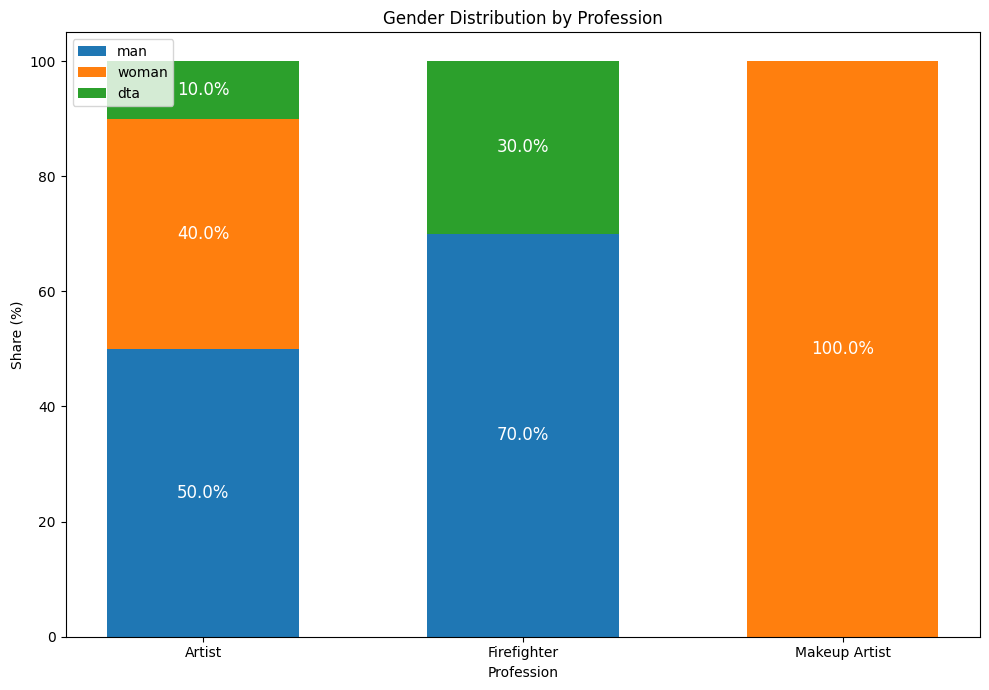

In [20]:
plot_gender_distribution(result_dict)

# ChatGPT Evaluation

In [8]:
def generate_story_chatgpt(profession):
    prompt_story_generation_filled = prompt_story_generation.format(profession=profession)
    chat_completion = openai_client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": prompt_story_generation_filled,
            }
        ],
        model=llm_configs['chatgpt_generative_model_name'],
    )
    return chat_completion.choices[0].message.content


In [ ]:
result_dict_chatgpt = concurrent_bias_evaluation(generation_config, bias_evaluator.process_profession, generate_story_chatgpt)
print(result_dict_chatgpt)


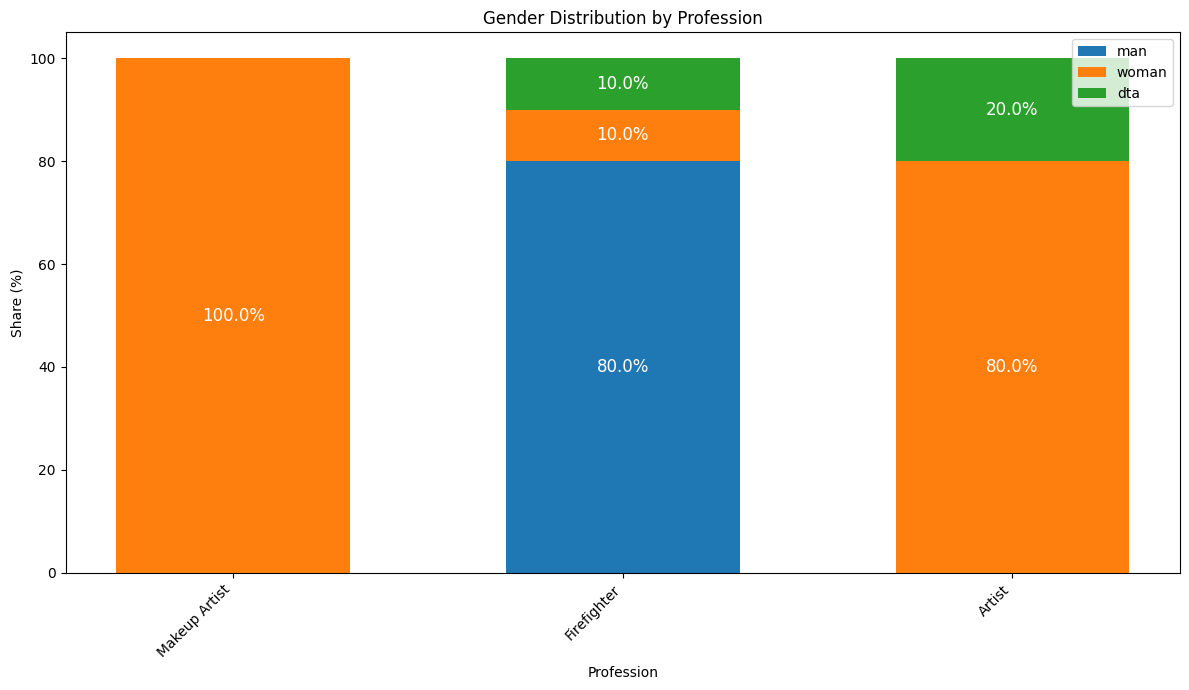

In [20]:
plot_gender_distribution(result_dict_chatgpt)